In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 5, 31), datetime.date(2022, 5, 29))

In [3]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,lly,3.048137
3,eve,2.531150
4,chmt,2.475858


<a href="https://www.advfn.com/nyse/newyorkstockexchange.asp?companies=I">NYSE listings</a>

In [6]:
KEEP_TOP_N = 50
sym = (
    'hcxz htgc htrg psv ht hsy htz hes hesm hpe hxl hgg hcr pcf hpr '
    'hglb hfro htpa hiw hil hrc hi hth hgv hlt hims hipo hrt hmlp hlly '
    'hfc homb hd hon hmn hzac hzon hzn htfa htfb hrl hos hst hli hov '
    'hhc hwm hnp hubs hubb hbm hud hpp hum htaq hcft hii hun h hyln hy '
    'iaa icl ida iex idt ihs info imax ing vate iaca iacb iacc io iqv'
)
missing = (
    'psv hgg hrc iaca htrg hos iacb hud hpr hzac hcft info hfc hcr')
SYMBOLS = [s for s in sym.split() if s not in missing.split()]
#SYMBOLS

In [7]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  62 of 62 completed


,hcxz,htgc,ht,hsy,htz,hes,hesm,hpe,hxl,pcf,...,ida,iex,idt,ihs,imax,ing,vate,iacc,io,iqv
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-31,36.249073,7.010655,NaN,39.811985,37.249973,NaN,NaN,NaN,NaN,59.869999,...,29.488390,5.003075,34.538334,NaN,21.240000,4.205911,90.899544,NaN,4.146920,-1.055822
2012-06-01,34.681118,6.800528,NaN,38.698483,36.354946,NaN,NaN,NaN,NaN,57.900002,...,29.270737,4.845973,33.442989,NaN,20.100000,4.031873,86.699570,NaN,4.110269,-1.040481
2012-06-04,34.739914,6.886488,NaN,39.343990,36.380520,NaN,NaN,NaN,NaN,56.759998,...,29.383327,4.936610,32.930092,NaN,19.190001,4.220414,86.399567,NaN,4.073617,-1.011801
2012-06-05,35.416100,6.934245,NaN,39.473095,36.661819,NaN,NaN,NaN,NaN,58.380001,...,29.713533,4.954736,33.199577,NaN,19.620001,4.256671,87.899559,NaN,4.099793,-1.029810
2012-06-06,36.660652,7.258991,NaN,40.828678,38.443336,NaN,NaN,NaN,NaN,60.540001,...,30.381519,5.045370,33.921108,NaN,19.950001,4.539484,94.349525,NaN,4.110269,-1.066493


In [8]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [9]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [10]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])
    
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

,stock,sharpe
32,hrl,1.320501
3,hsy,1.016135
16,hth,0.944214
54,idt,0.902013
40,hubb,0.897669
11,hfro,0.849511
23,hlly,0.807683
59,iacc,0.806390
41,hbm,0.779494
30,htfa,0.778025


In [11]:
sharpes = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ignore_index=True, ascending=False)
    .drop_duplicates())
sharpes.head(20)

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,lly,3.048137
3,eve,2.531150
4,chmt,2.475858
5,hhs,2.406309
6,bxsl,2.249160
7,APSG,2.178348
8,dwin,1.886962
9,cc,1.678946


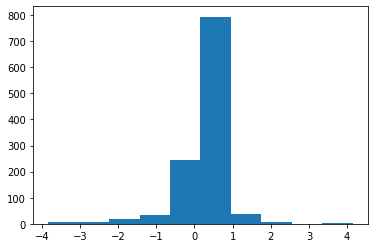

In [12]:
plt.hist(sharpes.sharpe);

In [13]:
sharpes.loc[sharpes.stock == 'CBX', :]

,stock,sharpe


In [14]:
omit = ('eg')
inds = []
for o in omit.split():
    inds += (sharpes.loc[sharpes.stock == o, :].index.tolist())

sharpes.drop(index=inds, inplace=True)

In [15]:
sharpes.to_csv('sharpes.csv', index=False)

In [16]:
sharpes.shape

(1160, 2)

In [23]:
MIX = sharpes.stock.unique().tolist()[:200]
len(MIX)
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
print(df.shape)
df.columns = MIX
MAX_MISSING = 1000
n_nan = df.isnull().sum()
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

[*********************100%***********************]  200 of 200 completed
(2521, 200)
(2521, 135)


,ASAN,efc,lly,chmt,bxsl,APSG,dwin,cc,cm,fmc,...,dri,bb,ggt,hpq,bowl,bmy,fpac,ens,gsqb,csr
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-31,31.647865,4.493657,17.466221,7.823708,24.365612,2.447454,9.613873,13.349495,NaN,13.784043,...,28.209999,31.503489,18.986689,8.489294,82.699440,44.879044,NaN,5.418609,115.304001,52.269840
2012-06-01,31.040422,4.203979,16.652712,7.757285,23.631891,2.285830,9.132271,12.830995,NaN,14.712968,...,27.330000,30.895725,18.691767,8.501054,82.002960,44.663807,NaN,5.418609,113.210693,51.797859
2012-06-04,31.151636,4.206890,16.693384,7.861662,23.601320,2.337780,9.214054,12.948522,NaN,14.702980,...,27.379999,30.888035,18.833328,8.548087,81.743813,44.071869,NaN,5.418609,114.285629,51.738033
2012-06-05,31.442533,4.222902,16.847948,7.970789,23.929960,2.349325,9.314008,13.107534,NaN,15.082541,...,27.629999,31.249611,18.756655,8.571601,82.472641,44.394749,NaN,5.299724,113.097504,51.585136
2012-06-06,31.904560,4.403405,17.515036,8.146334,24.587252,2.476315,9.504831,13.321840,NaN,15.751766,...,28.459999,31.549641,19.216724,8.624513,83.833176,44.663807,NaN,5.299724,118.019691,53.300209


In [24]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

hrl   : 0.16297
AFI   : 0.03635
AMT   : 0.02296
evh   : 0.02817
clr   : 0.05562
hae   : 0.0483
AVD   : 0.01807
ABM   : 0.11221
dco   : 0.04493
cat   : 0.00778
gl    : 0.04238
uan   : 0.04096
cnm   : 0.01688
ida   : 0.06258
bam   : 0.03453
bb    : 0.16552
ens   : 0.09978


In [25]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 20.5%
Annual volatility: 12.7%
Sharpe Ratio: 1.46


In [26]:
s1

1.4640000551699675